In [ ]:
import numpy as np
import librosa.display
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from vmdpy import VMD
import torch
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Github audio spectogram classification: https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb

In [ ]:
def apply_vmd(audio_path, alpha=2000, tau=0, K=3, DC=0, init=1, tol=1e-7):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)
    t = np.arange(len(y)) / sr  # Time vector

    # Perform VMD
    u, _, _ = VMD(y, alpha, tau, K, DC, init, tol)
    return u  # u contains the decomposed modes


In [ ]:
# Normalization: https://medium.com/@poudelnipriyanka/audio-normalization-9dbcedfefcc0

# https://ismir2018.ismir.net/doc/pdfs/189_Paper.pdf

def z_score_normalize(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    normalized_signal = (signal - mean) / std
    return normalized_signal


In [ ]:


def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close()
    

In [ ]:
test_audio_filepath = "/Users/user/Desktop/github_repos/als-project/data/VOC-ALS/ALS/A/PZ001_phonationA.wav"

folder_spectograms= "spectograms"

relative_path = os.path.dirname(test_audio_filepath)

output_path =os.path.join(relative_path, folder_spectograms)

if not os.path.exists(output_path):
        os.makedirs(output_path)

test_png_filepath = os.path.join(output_path,os.path.basename(test_audio_filepath)).replace(".wav", ".png")

In [ ]:
df_paths = pd.read_csv("/Users/user/Desktop/github_repos/als-project/data/final_consolidated_dataset_Fletcher.csv")

df_paths_als = df_paths[df_paths["Dataset"].isin(['VOC-ALS', 'MINSK'])]


In [ ]:
spectogram_filepath = []
for file in df_paths_als["file_path"]:
    print(file)

    folder_spectograms= "spectograms"

    relative_path = os.path.dirname(file)

    output_path =os.path.join(relative_path, folder_spectograms)

    if not os.path.exists(output_path):
            os.makedirs(output_path)

    png_filepath = os.path.join(output_path,os.path.basename(file)).replace(".wav", ".png")
    print(png_filepath)
    spectogram_filepath.append(png_filepath)

    # create_spectrogram(file, png_filepath)

# create_spectrogram(test_audio_filepath, test_png_filepath)

In [ ]:
df_paths_als.insert(loc=2,column="spectograma_file_path", value=spectogram_filepath)

In [ ]:
df_paths_als

In [ ]:
# Convert the label
df_paths_als['label'] = df_paths_als['label'].map({'ALS': 1, 'HC': 0})
df_paths_als


In [ ]:
def load_images_from_path(path, label):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    if os.path.isfile(path):  # Ensure it's a file
        img = Image.open(path).convert("RGB")  # Ensure 3 channels
        image = transform(img)  # Apply transformations
        # Ensure that the label is returned properly
        return image, label
    return None, None  # Return None if path is not a valid file



In [ ]:
def show_images(images, n_rows=1, n_cols=8):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})
    axes = axes.flatten()  # Flatten in case of a multi-row grid

    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i].permute(1, 2, 0).numpy())  # Convert tensor to NumPy (PyTorch case)
        else:
            ax.axis('off')  # Hide extra subplots if images < n_rows * n_cols

    plt.tight_layout()
    plt.show()

In [ ]:
df_paths_als_a = df_paths_als[df_paths_als["Phoneme"].isin(["A","a"])]


In [ ]:

x = []  # List to store images
y = []  # List to store labels

for i, row in df_paths_als_a.iterrows():
    path = row['spectograma_file_path']
    label = row['label']
    print(f"Label: {label}, Path: {path}")

    # Load the image and label
    image, label = load_images_from_path(path, label)
    
    if image is not None:  # Check if the image was loaded successfully
        x.append(image)
        y.append(label)

# Convert x and y to tensors if needed for training
x = torch.stack(x)  # Stack images into a tensor
y = torch.tensor(y)  # Convert labels to a tensor

# Optional: Check shapes
print(f"x shape: {x.shape}, y shape: {y.shape}")

In [ ]:
show_images(x)  # Pass the image inside a list

In [ ]:


# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

# Normalize pixel values by dividing by 255 (assuming x is an array of images)
x_train_norm = np.array(x_train) / 255.0
x_test_norm = np.array(x_test) / 255.0

# Convert the normalized images to PyTorch tensors
x_train_tensor = torch.tensor(x_train_norm, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_norm, dtype=torch.float32)

# Convert labels to one-hot encoding using PyTorch
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Use one-hot encoding (for binary/multi-class classification)
y_train_one_hot = F.one_hot(y_train_tensor, num_classes=len(np.unique(y)))  # Adjust num_classes as needed
y_test_one_hot = F.one_hot(y_test_tensor, num_classes=len(np.unique(y)))  # Adjust num_classes as needed

# Optional: Check shapes
print(f"x_train_tensor shape: {x_train_tensor.shape}, y_train_one_hot shape: {y_train_one_hot.shape}")
print(f"x_test_tensor shape: {x_test_tensor.shape}, y_test_one_hot shape: {y_test_one_hot.shape}")



In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # (224, 224, 3) -> (224, 224, 32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1)  # (224, 224, 32) -> (224, 224, 128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)  # (224, 224, 128) -> (224, 224, 128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)  # (224, 224, 128) -> (224, 224, 128)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 14 * 14, 1024)  # After pooling, the image size is reduced to (14, 14)
        self.fc2 = nn.Linear(1024, 4)  # 4 classes for classification

        # Activation function
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # For multi-class classification

    def forward(self, x):
        # Apply the layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 14 * 14)  # Flatten the tensor

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        # Softmax for classification
        x = self.softmax(x)
        
        return x

# Instantiate the model
model = CNNModel()

# Print model architecture
print(model)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss combines softmax and cross-entropy loss


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming x_train_norm, y_train_one_hot, x_test_norm, y_test_one_hot are already in tensor format
# Create DataLoader for batching
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters
        
        running_loss += loss.item() * inputs.size(0)  # Track the loss
        _, predicted = torch.max(outputs, 1)  # Get predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Track accuracy

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients for validation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = correct / total
    print(f'Validation Accuracy after Epoch {epoch+1}: {val_acc:.4f}')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn import functional as F

In [ ]:


# Preprocessing function for MobileNetV2
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split the dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

# Normalize pixel values (if you haven't done so)
x_train_norm = np.array(x_train) / 255.0
x_test_norm = np.array(x_test) / 255.0

# Convert the numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train_norm, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_norm, dtype=torch.float32)

# Convert the labels to long tensors for PyTorch (no need for one-hot encoding in multi-class classification)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# MobileNetV2 model setup
model = models.mobilenet_v2(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, len(np.unique(y)))  # Adjust output size based on your unique labels
)

# Move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

# Validation loop
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = correct / total
print(f'Validation Accuracy: {val_acc:.4f}')

# Confusion Matrix
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())



In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'ALS'], yticklabels=['Healthy', 'ALS'])


In [ ]:
import matplotlib.pyplot as plt


# MobileNetV2 model setup
model = models.mobilenet_v2(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, len(np.unique(y)))  # Adjust output size based on your unique labels
)

# Move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Initialize lists to store accuracy values
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_accuracies.append(epoch_acc)  # Store training accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = correct / total
    val_accuracies.append(val_acc)  # Store validation accuracy
    print(f'Validation Accuracy: {val_acc:.4f}')

# Plotting the accuracy
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
def save_spectograms(paths, folder_to_create="spectograms"):

    new_file_paths = []

    for file in paths:
        print("Original file:",file)

        relative_path = os.path.dirname(file)

        output_path =os.path.join(relative_path, folder_to_create)

        if not os.path.exists(output_path):
                os.makedirs(output_path)

        png_filepath = os.path.join(output_path,os.path.basename(file)).replace(".wav", ".png")
        new_file_paths.append(png_filepath)
        

        if os.path.isfile(png_filepath):
             print("New file exists.")
        elif not os.path.isfile(png_filepath):
            create_spectrogram(file, png_filepath)
            print("New file", png_filepath)
        else:
             print("An error occured")

    return new_file_paths

In [ ]:
df_voiced['Dataset'].unique()

In [ ]:
df_voiced = pd.read_csv("/Users/user/Desktop/github_repos/als-project/final_metadata_acoustic_features.csv")

df_voiced_pd = df_voiced[df_voiced["Dataset"].isin(["PD_dataset_2", "PD_dataset_1", "PD_dataset_3", "Italian"])]

df_voiced_pd_a = df_voiced_pd[df_voiced_pd['Phoneme'].isin(["A", "a"])]

df_voiced_pd_a.loc[:,'label'] = df_voiced_pd_a.loc[:,'label'].map({'PD': 1, 'HC': 0})
df_voiced_pd_a

In [ ]:
new_filepaths = save_spectograms(df_voiced_pd_a['voiced_file_path'])

In [ ]:
df_voiced_pd_a.insert(loc=2, column="spectogram_file_path", value=new_filepaths)

In [ ]:
def get_images_labels(image_paths, labels):

    x = []  # List to store images
    y = []  # List to store labels

    for path, label in zip(image_paths, labels):
        print(f"Label: {label}, Path: {path}")

        # Load the image and label
        image, label = load_images_from_path(path, label)
        
        if image is not None:  # Check if the image was loaded successfully
            x.append(image)
            y.append(label)

    # Convert x and y to tensors if needed for training
    x = torch.stack(x)  # Stack images into a tensor
    y = torch.tensor(y)  # Convert labels to a tensor

    # Optional: Check shapes
    print(f"x shape: {x.shape}, y shape: {y.shape}")

    return x, y

In [ ]:
x, y = get_images_labels(df_voiced_pd_a["spectogram_file_path"], df_voiced_pd_a['label'])

In [ ]:
show_images(x)

In [ ]:
def split_tensorize(x,y):
    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

    # Convert the  images to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Convert labels to one-hot encoding using PyTorch
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Optional: Check shapes
    print(f"x_train_tensor shape: {x_train_tensor.shape}, y_train_one_hot shape: {y_train_tensor.shape}")
    print(f"x_test_tensor shape: {x_test_tensor.shape}, y_test_one_hot shape: {y_train_tensor.shape}")

    return x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor

In [ ]:
x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = split_tensorize(x,y)

In [ ]:
import matplotlib.pyplot as plt


# MobileNetV2 model setup
model = models.mobilenet_v2(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, len(np.unique(y)))  # Adjust output size based on your unique labels
)

# Move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Initialize lists to store accuracy values
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_accuracies.append(epoch_acc)  # Store training accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = correct / total
    val_accuracies.append(val_acc)  # Store validation accuracy
    print(f'Validation Accuracy: {val_acc:.4f}')

# Plotting the accuracy
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# Confusion Matrix

def get_confusion_matrix(model, test_loader):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())


    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'ALS'], yticklabels=['Healthy', 'PD'])
    plt.show()

get_confusion_matrix(model, test_loader)

In [ ]:
import torchvision.transforms as transforms
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

In [ ]:
df_voiced = pd.read_csv("/Users/user/Desktop/github_repos/als-project/final_metadata_acoustic_features.csv")


In [ ]:
df_voiced.columns.to_list()

In [ ]:
updated_column_names = df_voiced.columns.to_list() + ["spectogram_file_path", "spectogram_type"]
updated_column_names

In [ ]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)

    # Truncate the frequency at 5 kHz and calculate Mel spectogram
    ms = librosa.feature.melspectrogram(y=y, sr=sr, fmax=5000)

    # Convert spectogram to decibel scale
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close()

In [ ]:
def create_augmented_spectogram(audio_file, image_file, augmented_image_file):

    # Open the saved image
    original_image = Image.open(image_file)

    # Flip the image horizontally
    flipped_image = original_image.transpose(Image.FLIP_LEFT_RIGHT)

    # Save the flipped image
    flipped_image.save(augmented_image_file)


In [ ]:
relative_path = "/Users/user/Desktop/github_repos/als-project"
updated_rows = []

orig_spectogram = "spectogram"
aug_spectogram = "augmented_spectogram"

n = 0 
for idx, row in df_voiced.iterrows():
    file_path = row['file_path']
    full_path = os.path.join(relative_path, file_path )
   
    one_dir_up = os.path.dirname(full_path)

    orig_spect = os.path.join(os.path.join(one_dir_up, orig_spectogram),os.path.basename(full_path))
    orig_spect = orig_spect.replace(".wav", ".png")

    if not os.path.exists(os.path.join(one_dir_up, orig_spectogram)):
        os.makedirs(os.path.join(one_dir_up, orig_spectogram))

    aug_spect = os.path.join(os.path.join(one_dir_up, aug_spectogram), os.path.basename(full_path))
    aug_spect = aug_spect.replace(".wav",  ".png")


    if not os.path.exists(os.path.join(one_dir_up, aug_spectogram)):
        os.makedirs(os.path.join(one_dir_up, aug_spectogram))

    new_row_orig = row.to_list() + [orig_spect, "original"]
    new_row_aug = row.to_list() + [aug_spect, "augmented"]
    updated_rows.append(new_row_orig)
    updated_rows.append(new_row_aug)

    create_spectrogram(full_path, orig_spect)
    create_augmented_spectogram(full_path, orig_spect, aug_spect)
    print(f"{n}. {full_path}")
    n += 1


df_voiced_orig_aug_spects = pd.DataFrame(updated_rows, columns=updated_column_names)

   




In [ ]:
relative_path = "/Users/user/Desktop/github_repos/als-project"
updated_rows = []

orig_spectogram = "spectogram"
aug_spectogram = "augmented_spectogram"

n = 0 
for idx, row in df_voiced.iterrows():
    file_path = row['file_path']
    full_path = os.path.join(relative_path, file_path )
   
    one_dir_up = os.path.dirname(full_path)

    orig_spect = os.path.join(os.path.join(one_dir_up, orig_spectogram),os.path.basename(full_path))
    orig_spect = orig_spect.replace(".wav", ".png")

    if not os.path.exists(os.path.join(one_dir_up, orig_spectogram)):
        os.makedirs(os.path.join(one_dir_up, orig_spectogram))

    aug_spect = os.path.join(os.path.join(one_dir_up, aug_spectogram), os.path.basename(full_path))
    aug_spect = aug_spect.replace(".wav",  ".png")


    if not os.path.exists(os.path.join(one_dir_up, aug_spectogram)):
        os.makedirs(os.path.join(one_dir_up, aug_spectogram))

    new_row_orig = row.to_list() + [orig_spect, "original"]
    new_row_aug = row.to_list() + [aug_spect, "augmented"]
    updated_rows.append(new_row_orig)
    updated_rows.append(new_row_aug)

    # Load image
    image = Image.open(orig_spect)

    # Crop
    left_crop = 20
    right_crop = 20
    top_crop = 45

    # Original dimensions
    width, height = image.size

    # New dimensions
    left = left_crop
    top = top_crop
    right = width - right_crop
    bottom = height

    # Crop image
    cropped_image = image.crop((left, top, right, bottom))
    cropped_image.save(orig_spect)
    
    
    create_augmented_spectogram(full_path, orig_spect, aug_spect)
    print(f"{n}. {full_path}")
    n += 1


df_voiced_orig_aug_spects = pd.DataFrame(updated_rows, columns=updated_column_names)

df_voiced_orig_aug_spects.to_csv("/Users/user/Desktop/github_repos/als-project/MAHRIS_spectogram_acoustic_features.csv")
   




In [ ]:
import pandas as pd
df_voiced_orig_aug_spects = pd.read_csv("/Users/user/Desktop/github_repos/als-project/spectogram_acoustic_features.csv")

In [ ]:
df_voiced_orig_aug_spects.columns.to_list()

In [ ]:
spectogram_file_paths = df_voiced_orig_aug_spects[df_voiced_orig_aug_spects['spectogram_type']=='original']["spectogram_file_path"]

display(spectogram_file_paths)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

for image_path in spectogram_file_paths:

    # Load image
    # image_path = spectogram_file_paths[0]
    image = Image.open(image_path)

    # Crop
    left_crop = 20
    right_crop = 20
    top_crop = 45

    # Original dimensions
    width, height = image.size

    # New dimensions
    left = left_crop
    top = top_crop
    right = width - right_crop
    bottom = height

    # Crop image
    cropped_image = image.crop((left, top, right, bottom))

    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Show the original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")  # Hide axis

    # Show the cropped image
    axes[1].imshow(cropped_image)
    axes[1].set_title("Cropped Image")
    axes[1].axis("off")  # Hide axis

    fig.patch.set_facecolor("blue")
    for ax in axes:
        ax.set_facecolor("blue")
        ax.patch.set_facecolor("blue")

    # Display the images
    plt.tight_layout()
    plt.show()


In [ ]:
df_voiced.Dataset.unique()

In [ ]:
dataset = ["PSP", "PD_dataset_2"]
label = ['HC', 'PSP']
df_dataset = df_voiced_orig_aug_spects[df_voiced_orig_aug_spects['Dataset'].isin(dataset)]
df_label = df_dataset[df_dataset['label'].isin(label)]
df_label.shape

In [ ]:
df_voiced = pd.read_csv("/Users/user/Desktop/github_repos/als-project/MAHRIS_spectogram_acoustic_features.csv")

dataset_choice = ["MSA", "PD_dataset_2"]
Phoneme_choice = ["I", "i"]
class_1 = 'MSA'
class_0 = 'HC'

df_voiced_als = df_voiced[(df_voiced["Dataset"].isin(dataset_choice))]

df_voiced_als_a = df_voiced_als[df_voiced_als['Phoneme'].isin(Phoneme_choice)]

df_voiced_als_a.loc[:,'label'] = df_voiced_als_a.loc[:,'label'].map({class_1: 1, class_0: 0})

df_voiced_als_a = df_voiced_als_a.dropna(subset=['label'])
df_voiced_als_a

In [ ]:
# Getting accuracy for all datasets

ALS_Phonemes = {"a":, "i":, "e":, "o": }
PD_Phonemes = {"a":, "i":, "e":, "o":}

In [ ]:
import ast

# File paths for the text files
files_mobilenet = {
    "PD_a": "FINAL_MB_spectogram_training_log_PD_a.txt",
    "PD_e": "/Users/user/Desktop/github_repos/als-project/FINAL_MB_spectogram_training_log_PD_e.txt",
    "PD_i": "/Users/user/Desktop/mobilenet_results/results_for_mhr/mobilenet_spectogram_training_log_PD_dataset_1_i.txt",
    "PD_o": "/Users/user/Desktop/mobilenet_results/results_for_mhr/mobilenet_spectogram_training_log_PD_dataset_1_o.txt",
    "PD_u": "/Users/user/Desktop/mobilenet_results/results_for_mhr/mobilenet_spectogram_training_log_PD_dataset_1_u.txt",



    "ALS_a": "/Users/user/Desktop/github_repos/als-project/FINAL_MB_spectogram_training_log_VOC-ALS_MINSK_a.txt",
    "ALS_e": "/Users/user/Desktop/github_repos/als-project/FINAL_MB_spectogram_training_log_VOC-ALS_MINSK_e.txt",
    "ALS_i": "/Users/user/Desktop/github_repos/als-project/FINAL_MB_spectogram_training_log_VOC-ALS_MINSK_i.txt",
    "ALS_o": "/Users/user/Desktop/github_repos/als-project/FINAL_MB_spectogram_training_log_VOC-ALS_MINSK_o.txt",
    "ALS_u": "/Users/user/Desktop/github_repos/als-project/FINAL_MB_spectogram_training_log_VOC-ALS_MINSK_u.txt",


    "MSA_a": "/Users/user/Desktop/github_repos/als-project/FINAL_MB_spectogram_training_log_MSA_pd2_HC_a.txt",
    "MSA_i": "/Users/user/Desktop/mobilenet_results/results_for_mhr/mobilenet_spectogram_training_log_MSA_i.txt",

    "PSP_a": "/Users/user/Desktop/mobilenet_results/results_for_mhr/mobilenet_spectogram_training_log_PSP_a.txt",
    "PSP_i": "/Users/user/Desktop/mobilenet_results/results_for_mhr/mobilenet_spectogram_training_log_PSP_i.txt",

}

files_resnet = {
    "PD_a": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PD_dataset_1_a.txt",
    "PD_e": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PD_dataset_1_e.txt",
    "PD_i": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PD_dataset_1_i.txt",
    "PD_o": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PD_dataset_1_o.txt",
    "PD_u": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PD_dataset_1_u.txt",



    "ALS_a": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_VOC-ALS_a.txt",
    "ALS_e": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_VOC-ALS_e.txt",
    "ALS_i": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_VOC-ALS_i.txt",
    "ALS_o": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_VOC-ALS_o.txt" ,
    "ALS_u": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_VOC-ALS_u.txt" ,


    "MSA_a": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_MSA_a.txt",
    "MSA_i": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_MSA_i.txt",

    "PSP_a": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PSP_a.txt",
    "PSP_i": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PSP_i.txt",
}

# Initialize the main dictionary
results = {}

# Keywords to identify the lines
keywords = {
    "epoch_losses": "Epochs loss:",
    "train_accuracies": "Train Accuracy:",
    "val_accuracies": "Validation Accuracy:"
}

# Function to extract values from a file
def extract_metrics(file_path):
    metrics = {"epoch_losses": [], "train_accuracies": [], "val_accuracies": []}
    with open(file_path, "r") as file:
        for line in file:
            if keywords["epoch_losses"] in line:
                metrics["epoch_losses"] = ast.literal_eval(line.split(keywords["epoch_losses"])[1].strip())
            elif keywords["train_accuracies"] in line:
                metrics["train_accuracies"] = ast.literal_eval(line.split(keywords["train_accuracies"])[1].strip())
            elif keywords["val_accuracies"] in line:
                metrics["val_accuracies"] = ast.literal_eval(line.split(keywords["val_accuracies"])[1].strip())
    return metrics

# Populate the dictionary
for identifier, file_path in files_mobilenet.items():
    results[identifier] = extract_metrics(file_path)

# Print the results dictionary
display(results)


{'PD_a': {'epoch_losses': [0.6805981877464918,
   0.6046968794093942,
   0.5486282411986177,
   0.47611280001184475,
   0.4200734169978016,
   0.3917202223209465,
   0.32623956469619797,
   0.265393225276995,
   0.22622290319241817,
   0.18890578496568608,
   0.17420473268384454,
   0.1700461965124562,
   0.1313182420372588,
   0.11119237495293408,
   0.09421004973492532,
   0.08885632638099059,
   0.06897960404086413,
   0.05895078774986777,
   0.04502980701578488,
   0.04858538361395118,
   0.03691682749011981,
   0.04092668652909357,
   0.030183116899533843,
   0.024112373567039862,
   0.021882322048709827,
   0.018047127120032813,
   0.018960880080483994,
   0.016327929152937244,
   0.018528319854265864,
   0.015452434452332603],
  'train_accuracies': [0.5581761006289309,
   0.6657223796033994,
   0.7422096317280453,
   0.7960339943342776,
   0.8356940509915014,
   0.8328611898016998,
   0.8838526912181303,
   0.9065155807365439,
   0.9305949008498584,
   0.9390934844192634,
   0.9

PD_a
PD_e
PD_i
PD_o
PD_u
ALS_a
ALS_e
ALS_i
ALS_o
ALS_u
MSA_a
MSA_i
PSP_a
PSP_i


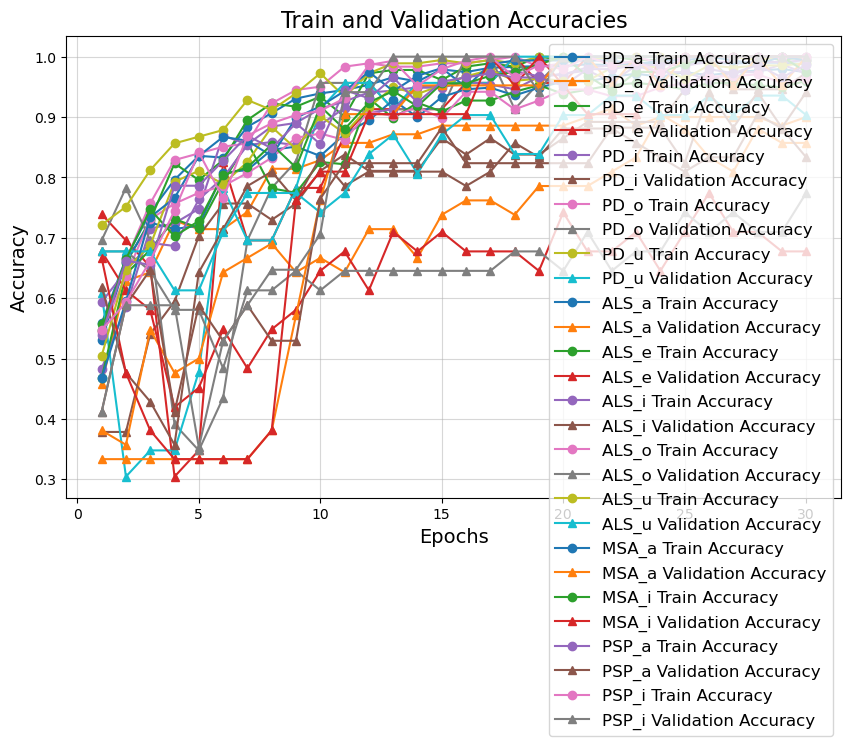

PD_a
PD_e
PD_i
PD_o
PD_u
ALS_a
ALS_e
ALS_i
ALS_o
ALS_u
MSA_a
MSA_i
PSP_a
PSP_i


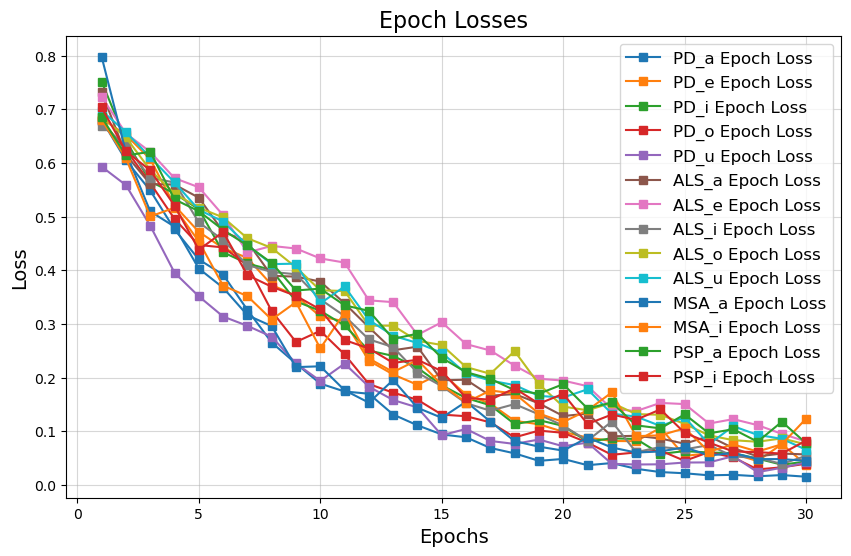

In [82]:
import matplotlib.pyplot as plt

# Plot all accuracies together
plt.figure(figsize=(10, 6))
for key, metrics in results.items():
    print(key)
    epochs = range(1, len(metrics["epoch_losses"]) + 1)  # Assuming epochs are sequential
    plt.plot(epochs, metrics["train_accuracies"], label=f"{key} Train Accuracy", marker='o')
    plt.plot(epochs, metrics["val_accuracies"], label=f"{key} Validation Accuracy", marker='^')

# Add title, labels, and legend
plt.title("Train and Validation Accuracies", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Plot all losses together
plt.figure(figsize=(10, 6))
for key, metrics in results.items():
    print(key)
    epochs = range(1, len(metrics["epoch_losses"]) + 1)  # Assuming epochs are sequential
    plt.plot(epochs, metrics["epoch_losses"], label=f"{key} Epoch Loss", marker='s')

# Add title, labels, and legend
plt.title("Epoch Losses", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()


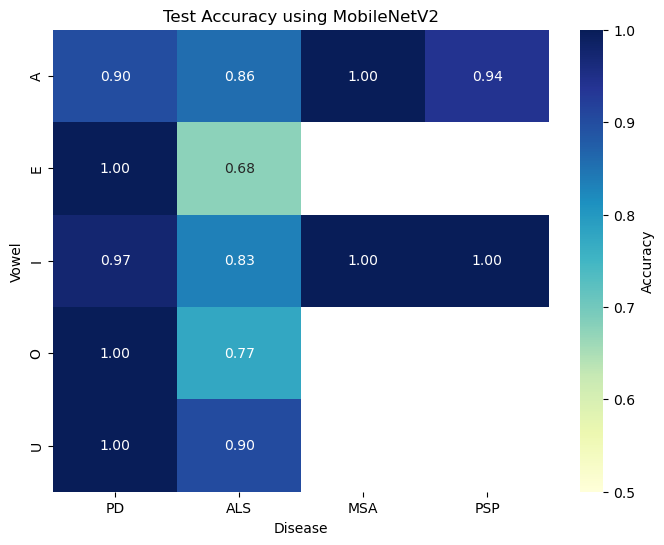

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your data structure
results_dict = results

# Create a DataFrame to hold the last validation accuracy for each key
data = []
for key, values in results_dict.items():
    disease = key.split("_")[0]  # Extract disease (e.g., "PD")
    vowel = key.split("_")[1].upper()  # Extract vowel (e.g., "a")
    last_val_acc = values["val_accuracies"][-1]  # Get the last validation accuracy
    data.append([disease, vowel, last_val_acc])

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=["Disease", "Vowel", "Accuracy"])

# Set a custom order for diseases
disease_order = [ "PD", "ALS", "MSA", "PSP"]
df["Disease"] = pd.Categorical(df["Disease"], categories=disease_order, ordered=True)

# Pivot to create a matrix suitable for heatmap
heatmap_data = df.pivot(columns="Disease", index="Vowel", values="Accuracy")

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap( heatmap_data, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    vmin=0.5,    # Set minimum color bar value
    vmax=1.0,    # Set maximum color bar value
    cbar_kws={'label': 'Accuracy'}
)
plt.title("Test Accuracy using MobileNetV2")
plt.ylabel("Vowel")
plt.xlabel("Disease")
plt.show()


In [ ]:
import ast

# File paths for the text files

files_resnet = {
    "PD_a": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PD_dataset_1_a.txt",
    "PD_e": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PD_dataset_1_e.txt",
    "PD_i": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PD_dataset_1_i.txt",
    "PD_o": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PD_dataset_1_o.txt",
    "PD_u": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PD_dataset_1_u.txt",



    "ALS_a": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_VOC-ALS_a.txt",
    "ALS_e": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_VOC-ALS_e.txt",
    "ALS_i": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_VOC-ALS_i.txt",
    "ALS_o": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_VOC-ALS_o.txt" ,
    "ALS_u": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_VOC-ALS_u.txt" ,


    "MSA_a": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_MSA_a.txt",
    "MSA_i": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_MSA_i.txt",

    "PSP_a": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PSP_a.txt",
    "PSP_i": "/Users/user/Desktop/mobilenet_results/results_for_mhr/resnet_spectogram_training_log_PSP_i.txt",
}

# Initialize the main dictionary
results = {}

# Keywords to identify the lines
keywords = {
    "epoch_losses": "Epochs loss:",
    "train_accuracies": "Train Accuracy:",
    "val_accuracies": "Validation Accuracy:"
}

# Function to extract values from a file
def extract_metrics(file_path):
    metrics = {"epoch_losses": [], "train_accuracies": [], "val_accuracies": []}
    with open(file_path, "r") as file:
        for line in file:
            if keywords["epoch_losses"] in line:
                metrics["epoch_losses"] = ast.literal_eval(line.split(keywords["epoch_losses"])[1].strip())
            elif keywords["train_accuracies"] in line:
                metrics["train_accuracies"] = ast.literal_eval(line.split(keywords["train_accuracies"])[1].strip())
            elif keywords["val_accuracies"] in line:
                metrics["val_accuracies"] = ast.literal_eval(line.split(keywords["val_accuracies"])[1].strip())
    return metrics

# Populate the dictionary
for identifier, file_path in files_resnet.items():
    results[identifier] = extract_metrics(file_path)

# Print the results dictionary
display(results)


{'PD_a': {'epoch_losses': [0.6439375554990469,
   0.538881075269771,
   0.3979356272977853,
   0.2465182124818646,
   0.14744743062827573,
   0.09634594104996642,
   0.05410644649850123,
   0.06847582554222091,
   0.035238928747298955,
   0.01978813295703639,
   0.025376188384263584,
   0.023519461625987816,
   0.01784009569904433,
   0.014205973671526654,
   0.02067766178094741,
   0.019894069040182438,
   0.016176686259045166,
   0.012134999536862303,
   0.013803194235986884,
   0.012836804920983201,
   0.009382039680491266,
   0.007874636528662072,
   0.0037353648738232704,
   0.03163751002852131,
   0.03445522576561725,
   0.04573264535159201,
   0.04917401254013087,
   0.030119422042695514,
   0.02572594231079514,
   0.022095336441138067],
  'train_accuracies': [0.6336477987421384,
   0.7620396600566572,
   0.8385269121813032,
   0.9178470254957507,
   0.943342776203966,
   0.943342776203966,
   0.9674220963172805,
   0.9631728045325779,
   0.9518413597733711,
   0.974504249291784

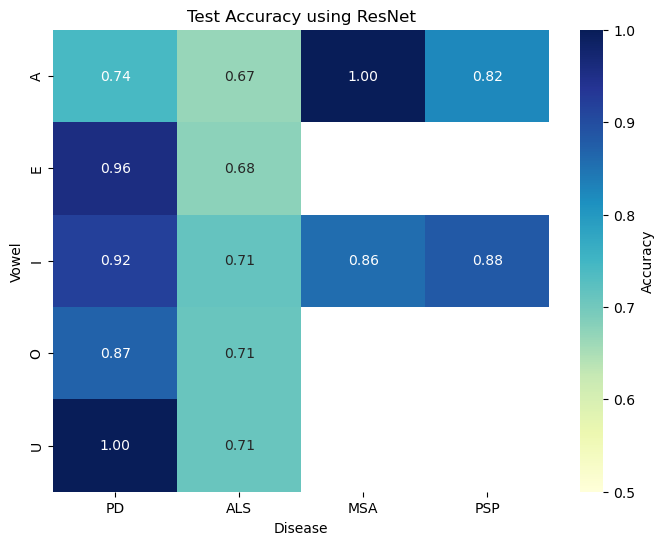

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your data structure
results_resnet = results

# Create a DataFrame to hold the last validation accuracy for each key
data = []
for key, values in results_resnet.items():
    disease = key.split("_")[0]  # Extract disease (e.g., "PD")
    vowel = key.split("_")[1].upper()  # Extract vowel (e.g., "a")
    last_val_acc = values["val_accuracies"][-1]  # Get the last validation accuracy
    data.append([disease, vowel, last_val_acc])

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=["Disease", "Vowel", "Accuracy"])

# Set a custom order for diseases
disease_order = ["PD", "ALS", "MSA", "PSP"]
df["Disease"] = pd.Categorical(df["Disease"], categories=disease_order, ordered=True)

# Pivot to create a matrix suitable for heatmap
heatmap_data = df.pivot(columns="Disease", index="Vowel", values="Accuracy")

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    vmin=0.5,    # Set minimum color bar value
    vmax=1.0,    # Set maximum color bar value
    cbar_kws={'label': 'Accuracy'}
)
plt.title("Test Accuracy using ResNet")
plt.ylabel("Vowel")
plt.xlabel("Disease")
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv("/Users/user/Desktop/github_repos/als-project/data/final_consolidated_dataset_Fletcher.csv")
df.label.unique(), df.Phoneme.unique()

(array(['ALS', 'HC', 'PD', 'MSA', 'PSP'], dtype=object),
 array(['A', 'E', 'I', 'O', 'U', 'a', 'i'], dtype=object))

In [ ]:
import pandas as pd

# Convert the 'Phoneme' column to lowercase to handle case insensitivity
df['Phoneme'] = df['Phoneme'].str.lower()

# Group by 'label' (Disease) and 'Phoneme' (Vowel), then count unique vowels
unique_vowel_count = df.groupby("label")["Phoneme"].nunique().reset_index()

# Rename the columns for clarity
unique_vowel_count.columns = ['Disease', 'Unique Vowels Count']

# Display the result
print(unique_vowel_count)


  Disease  Unique Vowels Count
0     ALS                    5
1      HC                    5
2     MSA                    2
3      PD                    5
4     PSP                    2


In [53]:
import pandas as pd

# Sample data (replace this with your actual DataFrame)
# Assuming the dataframe is df and contains 'label' for disease and 'Phoneme' for vowel

# Example: df = pd.DataFrame(data)

# Convert the 'Phoneme' column to lowercase to handle case insensitivity
df['Phoneme'] = df['Phoneme'].str.lower()

# Group by 'label' (Disease) and 'Phoneme' (Vowel), then count the occurrences
vowel_counts = df.groupby(['label', 'Phoneme']).size().reset_index(name='Count')

# Pivot to create a table where diseases are rows and vowels are columns
vowel_counts_pivot = vowel_counts.pivot(index='label', columns='Phoneme', values='Count').fillna(0)

# Display the result
print(vowel_counts_pivot)


Phoneme      a      e      i      o      u
label                                     
ALS      133.0  102.0  133.0  102.0  102.0
HC       284.0   95.0  172.0   95.0   95.0
MSA       42.0    0.0   42.0    0.0    0.0
PD       198.0   55.0  100.0   55.0   55.0
PSP       36.0    0.0   36.0    0.0    0.0


In [ ]:
pd_2 = df[df['Dataset']=='PD_dataset_2']
pd2_hc = pd_2[pd_2['label']=="HC"]
len(pd2_hc[pd2_hc['Phoneme']=="i"])

44

In [68]:
als = df[df['Dataset'].isin(['VOC-ALS', 'MINSK'])]
als_label = als[als['label']=="HC"]
len(als_label[als_label['Phoneme']=='u'])

51

In [74]:
als = df[df['Dataset'].isin(['Italian', 'PD_dataset_1', 'PD_dataset_2', 'PD_dataset_3'])]
als_label = als[als['label']=="HC"]
len(als_label[als_label['Phoneme']=='u'])

44